Baixando dados

In [ ]:
!unzip trainval-efficientnetb3.zip

Archive:  trainval-efficientnetb3.zip
  inflating: trainval-efficientnetb3.csv  
  inflating: train_id_codes.txt      
  inflating: val_id_codes.txt        


Imports iniciais

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
SEED = 564258

Separando treino e teste

In [ ]:
data = pd.read_csv('trainval-efficientnetb3.csv')

In [ ]:
train_ids = pd.read_csv('train_id_codes.txt', header=None)
train_ids = train_ids.to_numpy().flatten()
train_ids

array(['c97472ef2c66', '81914ceb4e74', '89d2a7403a06', ...,
       'b0eeae01b8ab', '4bcee3cbe232', '7455e2b5fc57'], dtype=object)

In [ ]:
train_index = data[data['id_code'].isin(train_ids)].index
val_index = data[~data['id_code'].isin(train_ids)].index
X_train = data.iloc[train_index, 1:-1].to_numpy()
X_val = data.iloc[val_index, 1:-1].to_numpy()
y_train = data.iloc[train_index, -1].to_numpy()
y_val = data.iloc[val_index, -1].to_numpy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2929, 1536), (733, 1536), (2929,), (733,))

In [ ]:
X_train[0], y_train[0]

(array([ 0.68126209,  1.64294089, -1.12589311, ...,  0.84743361,
         2.15995938,  0.09631934]),
 np.int64(2))

In [ ]:
X_train.mean(), X_train.std()

(np.float64(1.1047545097412875e-16), np.float64(0.9999999999999998))

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, average='weighted')

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}

NUM_TRIES = 3
outer_kf = KFold(n_splits=NUM_TRIES, shuffle=True, random_state=SEED)
svc = SVC()
# nested cross validation
models = []
metrics = []
for i, (tr_index, va_index) in enumerate(outer_kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train[tr_index], X_train[va_index]
    y_train_fold, y_val_fold = y_train[tr_index], y_train[va_index]

    inner_kf = KFold(n_splits=5, shuffle=True, random_state=SEED + 1 + i)
    grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3, cv=inner_kf, scoring=f1_scorer)
    grid.fit(X_train_fold, y_train_fold)

    models.append(grid.best_estimator_)
    metrics.append(grid.best_score_) # avg weighted f1score


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.293 total time=   4.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.318 total time=   4.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.319 total time=   4.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.339 total time=   4.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.362 total time=   4.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.293 total time=   4.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.318 total time=   3.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.319 total time=   4.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.339 total time=   4.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.362 total time=   4.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.293 total time=   4.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [ ]:
models

[SVC(C=10, gamma=0.0001), SVC(C=10, gamma=0.0001), SVC(C=10, gamma=0.0001)]

In [ ]:
metrics

[np.float64(0.7872500015751106),
 np.float64(0.7921503785048365),
 np.float64(0.7760589929986779)]

In [ ]:
np.mean(metrics), np.std(metrics)

(np.float64(0.7851531243595417), np.float64(0.006734530046451256))

In [ ]:
best_model = models[np.argmax(metrics)]
best_model

SVC(C=10, gamma=0.0001)

In [ ]:
import joblib

# Define the filename for your model
model_filename = 'best_svc_model.joblib'

# Save the model to the file
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to best_svc_model.joblib


In [ ]:
joblib.dump(models[0], 'best_svc_model_0.joblib')
joblib.dump(models[1], 'best_svc_model_1.joblib')
joblib.dump(models[2], 'best_svc_model_2.joblib')

['best_svc_model_2.joblib']

In [ ]:
f1_scorer(best_model, X_val, y_val)

0.7868899337012688

Accuracy: 0.800818553888131
Precision: 0.7892693063720824
Recall: 0.800818553888131
F1score: 0.7868899337012688
Kappa: 0.8649576923583056


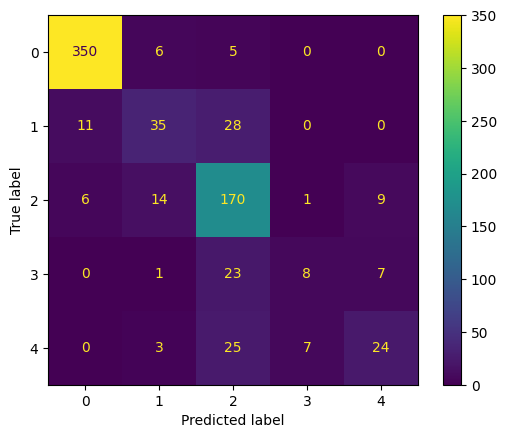

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, ConfusionMatrixDisplay

y_pred = best_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred, average='weighted'))
print("Recall:", recall_score(y_val, y_pred, average='weighted'))
print("F1score:", f1_score(y_val, y_pred, average='weighted'))
print("Kappa:", cohen_kappa_score(y_val, y_pred, weights='quadratic'))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred)

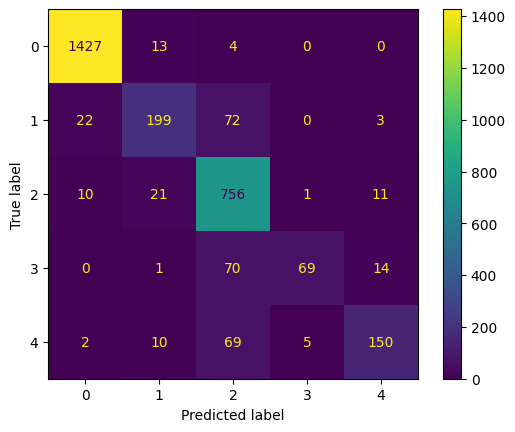

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, best_model.predict(X_train))